<a href="https://colab.research.google.com/github/Raashidh-Rizvi/Brain-Tumor-Detection/blob/main/G41_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!git clone https://github.com/Raashidh-Rizvi/Brain-Tumor-Detection.git


train_dir = "/content/Brain-Tumor-Detection/data/Training"
test_dir = "/content/Brain-Tumor-Detection/data/Testing"



Cloning into 'Brain-Tumor-Detection'...
remote: Enumerating objects: 6876, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 6876 (delta 37), reused 10 (delta 0), pack-reused 6760 (from 3)
Receiving objects: 100% (6876/6876), 146.21 MiB | 15.86 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Updating files: 100% (7039/7039), done.


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import exposure

Files in notumor (Training): ['Tr-no_1289.jpg', 'Tr-no_0697.jpg', 'Tr-no_0450.jpg', 'Tr-noTr_0005.jpg', 'Tr-no_1532.jpg']...
Files in meningioma (Training): ['Tr-me_0322.jpg', 'Tr-me_1304.jpg', 'Tr-me_0840.jpg', 'Tr-me_1295.jpg', 'Tr-me_0451.jpg']...
Files in glioma (Training): ['Tr-gl_0670.jpg', 'Tr-gl_0497.jpg', 'Tr-gl_0348.jpg', 'Tr-gl_0982.jpg', 'Tr-gl_0376.jpg']...
Files in pituitary (Training): ['Tr-pi_0578.jpg', 'Tr-pi_0555.jpg', 'Tr-pi_0040.jpg', 'Tr-pi_1116.jpg', 'Tr-pi_1335.jpg']...
Files in notumor (Testing): ['Te-no_0335.jpg', 'Te-no_0230.jpg', 'Te-no_0341.jpg', 'Te-no_0370.jpg', 'Te-no_0064.jpg']...
Files in meningioma (Testing): ['Te-me_0156.jpg', 'Te-me_0026.jpg', 'Te-me_0094.jpg', 'Te-me_0075.jpg', 'Te-me_0167.jpg']...
Files in glioma (Testing): ['Te-gl_0041.jpg', 'Te-gl_0115.jpg', 'Te-gl_0055.jpg', 'Te-gl_0186.jpg', 'Te-gl_0174.jpg']...
Files in pituitary (Testing): ['Te-pi_0081.jpg', 'Te-pi_0083.jpg', 'Te-pi_0233.jpg', 'Te-pi_0010.jpg', 'Te-piTr_0003.jpg']...
Initial 

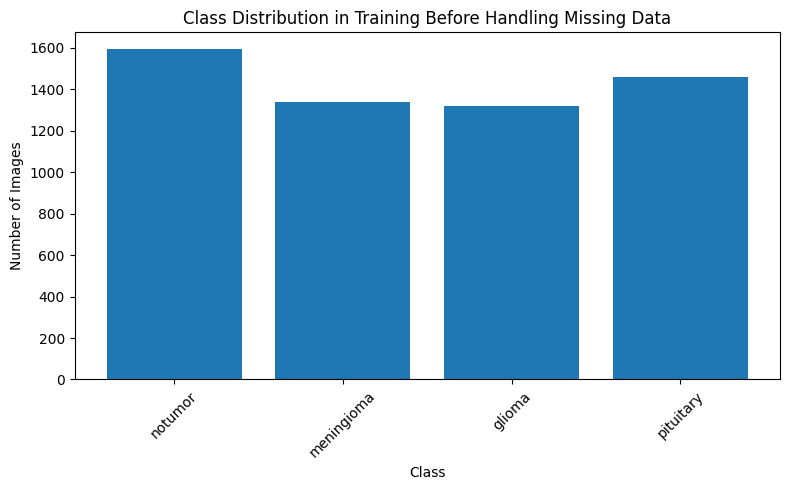

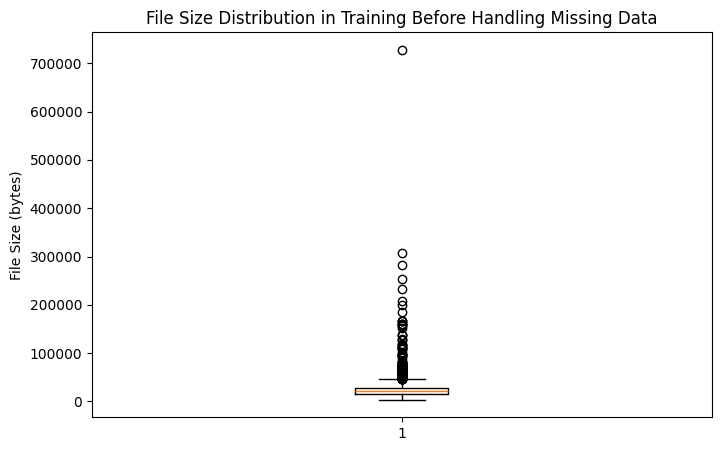

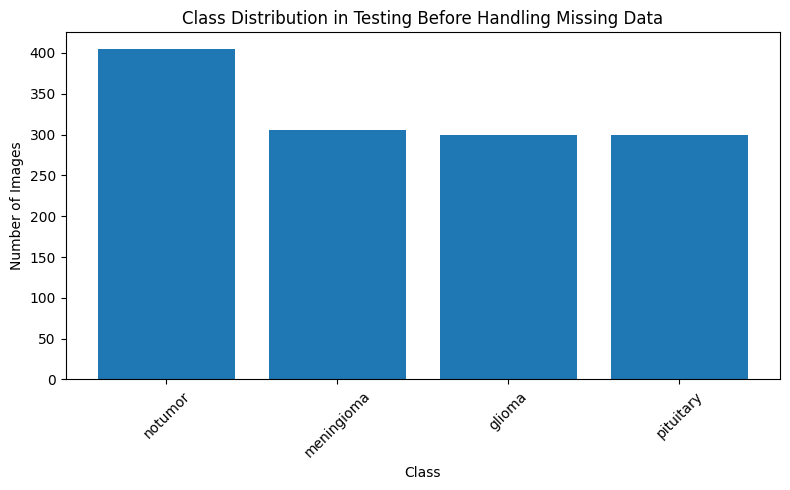

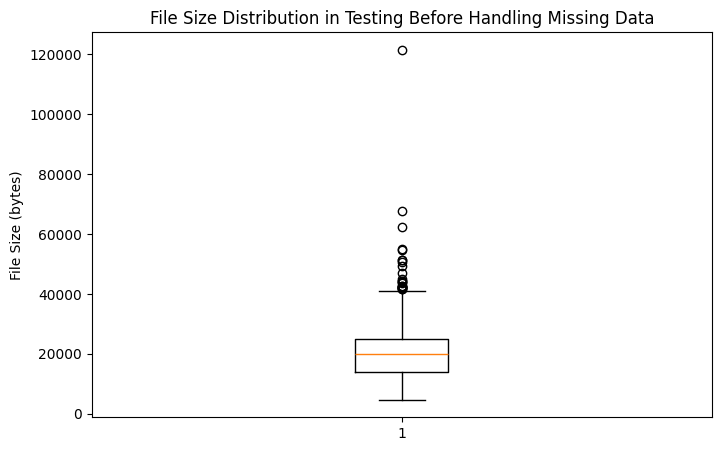

Total valid images after handling: 7023
Image counts after handling missing data: {'Training': Counter({'notumor': 1595, 'pituitary': 1457, 'meningioma': 1339, 'glioma': 1321}), 'Testing': Counter({'notumor': 405, 'meningioma': 306, 'glioma': 300, 'pituitary': 300})}


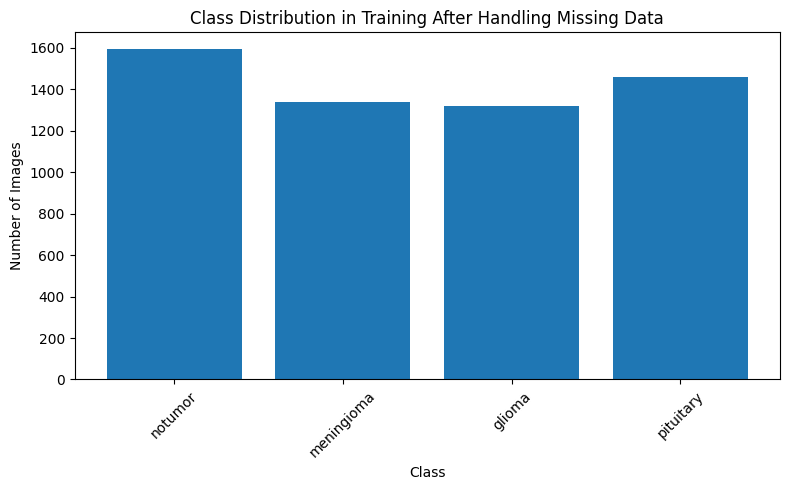

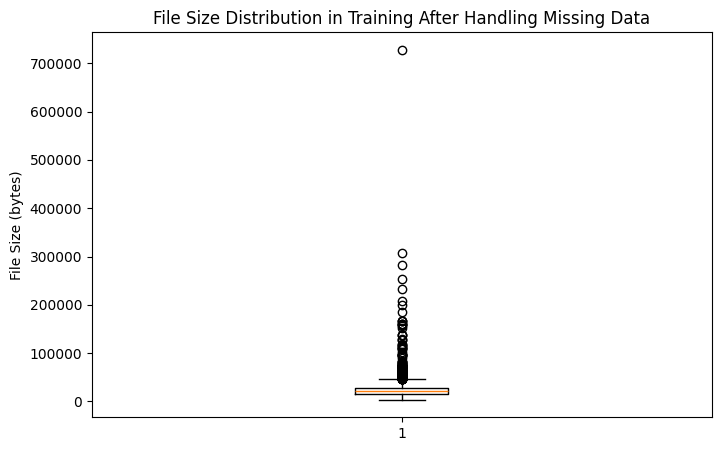

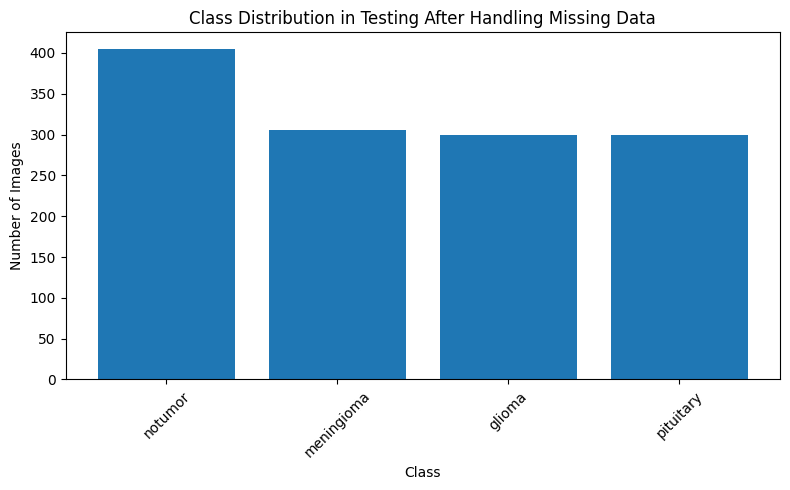

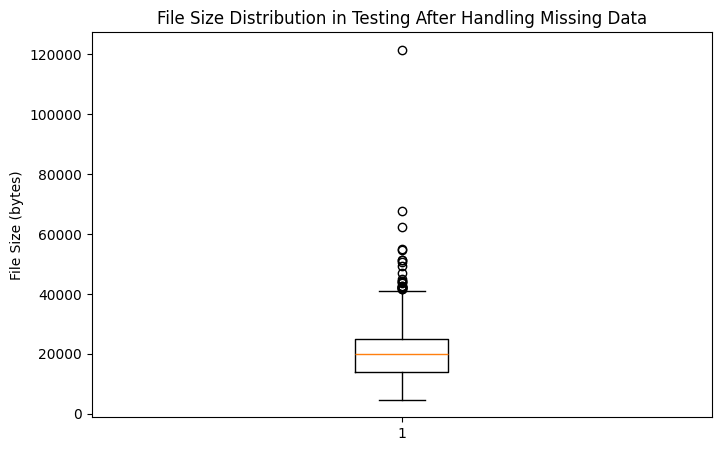

In [8]:
# Step 3: Initial EDA - Count images before handling missing data
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import exposure
from collections import Counter # Import Counter here

splits = ['Training', 'Testing']
split_dirs = {'Training': train_dir, 'Testing': test_dir}
# Updated classes based on actual subfolder names
classes = ['notumor', 'meningioma', 'glioma', 'pituitary']
initial_counts = {split: {} for split in splits}
image_sizes = {split: [] for split in splits}  # For box plots
for split in splits:
    split_path = split_dirs[split]
    if os.path.exists(split_path):
        for cls in classes:
            class_path = os.path.join(split_path, cls)
            if os.path.exists(class_path):
                image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.JPG'))]
                print(f"Files in {cls} ({split}): {image_files[:5]}...")  # Show first 5 files
                initial_counts[split][cls] = len(image_files)
                for img_file in image_files:
                    img_path = os.path.join(class_path, img_file)
                    try:
                        img_size = os.path.getsize(img_path)  # Size in bytes
                        image_sizes[split].append(img_size)
                    except Exception as e:
                        print(f"Error getting size for {img_path}: {e}")
print("Initial image counts:", initial_counts)

# Visualize initial distribution with bar and box plots
for split in splits:
    if initial_counts[split]:  # Bar plot for counts
        plt.figure(figsize=(8, 5))
        plt.bar(initial_counts[split].keys(), initial_counts[split].values())
        plt.title(f"Class Distribution in {split} Before Handling Missing Data")
        plt.xlabel("Class")
        plt.ylabel("Number of Images")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data to plot for {split} (bar plot)")
    if image_sizes[split]:  # Box plot for file sizes
        plt.figure(figsize=(8, 5))
        plt.boxplot(image_sizes[split])
        plt.title(f"File Size Distribution in {split} Before Handling Missing Data")
        plt.ylabel("File Size (bytes)")
        plt.show()
    else:
        print(f"No data to plot for {split} (box plot)")

# Step 4: Handle missing Data
# Justification: Removing corrupted images ensures the model doesn't crash during training; essential for our image-based dataset.
valid_images = {split: [] for split in splits}
valid_labels = {split: [] for split in splits}
for split in splits:
    split_path = split_dirs[split]
    if os.path.exists(split_path):
        for cls in classes:
            class_path = os.path.join(split_path, cls)
            if os.path.exists(class_path):
                image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.JPG'))]
                for img_file in image_files:
                    img_path = os.path.join(class_path, img_file)
                    try:
                        img = cv2.imread(img_path)
                        if img is None:
                            raise ValueError("Image is corrupted")
                        valid_images[split].append(img_path)
                        valid_labels[split].append(cls)
                    except Exception as e:
                        print(f"Removing missing/corrupted image in {split}: {img_path} (Error: {e})")

print(f"Total valid images after handling: {sum(len(valid_images[split]) for split in splits)}")

# Step 5: Post-handling EDA
valid_counts = {split: Counter(valid_labels[split]) for split in splits}
print("Image counts after handling missing data:", valid_counts)

# Visualize post-handling distribution with bar and box plots
for split in splits:
    if valid_counts[split]:  # Bar plot for counts
        plt.figure(figsize=(8, 5))
        plt.bar(valid_counts[split].keys(), valid_counts[split].values())
        plt.title(f"Class Distribution in {split} After Handling Missing Data")
        plt.xlabel("Class")
        plt.ylabel("Number of Images")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data to plot for {split} (bar plot)")
    if image_sizes[split]:  # Box plot for file sizes
        plt.figure(figsize=(8, 5))
        plt.boxplot(image_sizes[split])
        plt.title(f"File Size Distribution in {split} After Handling Missing Data")
        plt.ylabel("File Size (bytes)")
        plt.show()
    else:
        print(f"No data to plot for {split} (box plot)")

# Step 6: Export visualizations for submission
output_dir = 'results/eda_visualizations'
os.makedirs(output_dir, exist_ok=True)
for split in splits:
    if initial_counts[split]:
        plt.figure(figsize=(8, 5))
        plt.bar(initial_counts[split].keys(), initial_counts[split].values())
        plt.title(f"Class Distribution in {split} Before Handling Missing Data")
        plt.xlabel("Class")
        plt.ylabel("Number of Images")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'{split}_before_bar.png'))
        plt.close()
    if valid_counts[split]:
        plt.figure(figsize=(8, 5))
        plt.bar(valid_counts[split].keys(), valid_counts[split].values())
        plt.title(f"Class Distribution in {split} After Handling Missing Data")
        plt.xlabel("Class")
        plt.ylabel("Number of Images")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'{split}_after_bar.png'))
        plt.close()
    if image_sizes[split]:
        plt.figure(figsize=(8, 5))
        plt.boxplot(image_sizes[split])
        plt.title(f"File Size Distribution in {split} Before Handling Missing Data")
        plt.ylabel("File Size (bytes)")
        plt.savefig(os.path.join(output_dir, f'{split}_before_box.png'))
        plt.close()

Total images found: 5712
Unique labels: {'notumor', 'pituitary', 'glioma', 'meningioma'}

Class Mapping (Label Encoding):
glioma → 0
meningioma → 1
notumor → 2
pituitary → 3

First 10 Encoded Labels: [1 1 1 1 1 1 1 1 1 1]

Shape of One-Hot Encoded Labels: (5712, 4)
Example (first 5 one-hot labels):
 [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


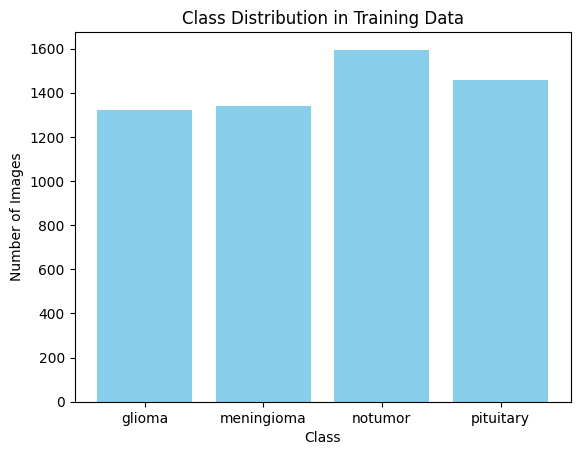

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical



# Step 1: Collect dataset paths & labels

image_paths = []
labels = []

# Each subfolder = class name
for class_name in os.listdir(train_dir):
    class_folder = os.path.join(train_dir, class_name)
    if os.path.isdir(class_folder):
        for img_name in os.listdir(class_folder):
            image_paths.append(os.path.join(class_folder, img_name))
            labels.append(class_name)   # raw string label

print("Total images found:", len(image_paths))
print("Unique labels:", set(labels))


# Step 2: Label Encoding

le = LabelEncoder()
label_encoded = le.fit_transform(labels)

print("\nClass Mapping (Label Encoding):")
for cls, idx in zip(le.classes_, range(len(le.classes_))):
    print(f"{cls} → {idx}")

print("\nFirst 10 Encoded Labels:", label_encoded[:10])


# Step 3: One-Hot Encoding

one_hot_labels = to_categorical(label_encoded)

print("\nShape of One-Hot Encoded Labels:", one_hot_labels.shape)
print("Example (first 5 one-hot labels):\n", one_hot_labels[:5])


# Step 4: EDA - Class Distribution

unique, counts = np.unique(labels, return_counts=True)
plt.bar(unique, counts, color="skyblue")
plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()



Training data shape: (5712, 224, 224, 3)
Testing data shape: (1311, 224, 224, 3)
Pixel value range: min = 0.0 , max = 1.0


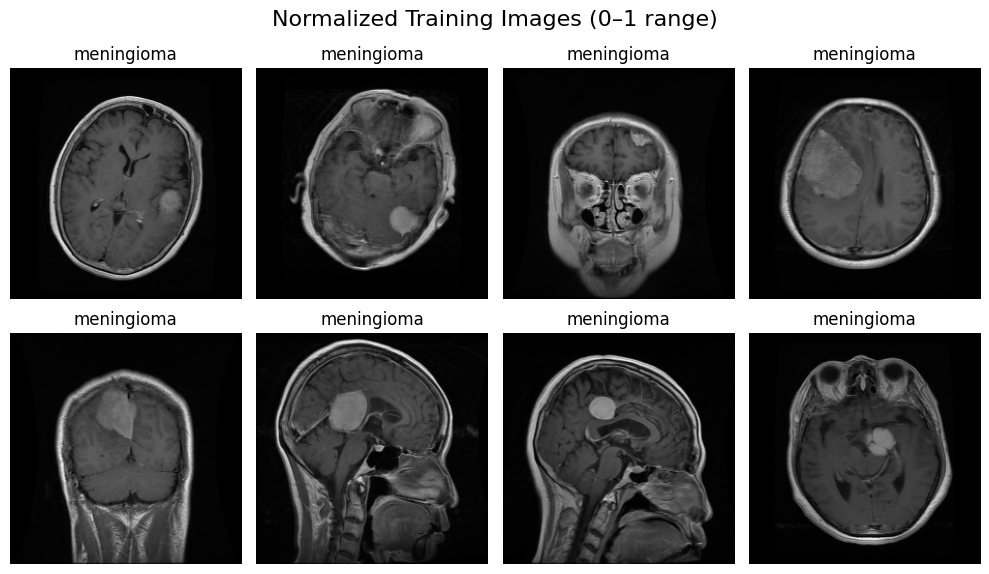

✅ Normalized dataset saved as .npy files


In [6]:
IMG_SIZE = (224, 224)

# --------------------------
# Step 2: Function to Load & Normalize Images
# --------------------------
def load_and_normalize_images(directory):
    images = []
    labels = []

    for class_name in os.listdir(directory):
        class_folder = os.path.join(directory, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)

                try:
                    # Load image
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, IMG_SIZE)   # Resize to (224x224)

                    # Normalization: scale 0–255 → 0–1
                    img = img.astype("float32") / 255.0

                    images.append(img)
                    labels.append(class_name)
                except:
                    print("Corrupted image skipped:", img_path)

    return np.array(images), np.array(labels)

# --------------------------
# Step 3: Apply to Training & Test Data
# --------------------------
X_train, y_train = load_and_normalize_images(train_dir)
X_test, y_test = load_and_normalize_images(test_dir)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Pixel value range: min =", X_train.min(), ", max =", X_train.max())

# --------------------------
# Step 4: Visualization
# --------------------------
plt.figure(figsize=(10,6))

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(X_train[i])
    plt.title(y_train[i])  # Show class label
    plt.axis("off")

plt.suptitle("Normalized Training Images (0–1 range)", fontsize=16)
plt.tight_layout()
plt.show()

# --------------------------
# Step 5: Save Normalized Data (optional)
# --------------------------
np.save("X_train_normalized.npy", X_train)
np.save("y_train_labels.npy", y_train)
np.save("X_test_normalized.npy", X_test)
np.save("y_test_labels.npy", y_test)

print("✅ Normalized dataset saved as .npy files")



Checking paths:
Glioma path exists: True
Meningioma path exists: True
Pituitary path exists: True
No tumor path exists: True

Number of images in each class:
Glioma: 1321
Meningioma: 1339
Pituitary: 1457
No tumor: 1595

Loading images...

Loaded 1321 glioma images
Loaded 1339 meningioma images
Loaded 1457 pituitary images
Loaded 1595 no tumor images

Total images: 5712
Image shape: (150, 150, 3)


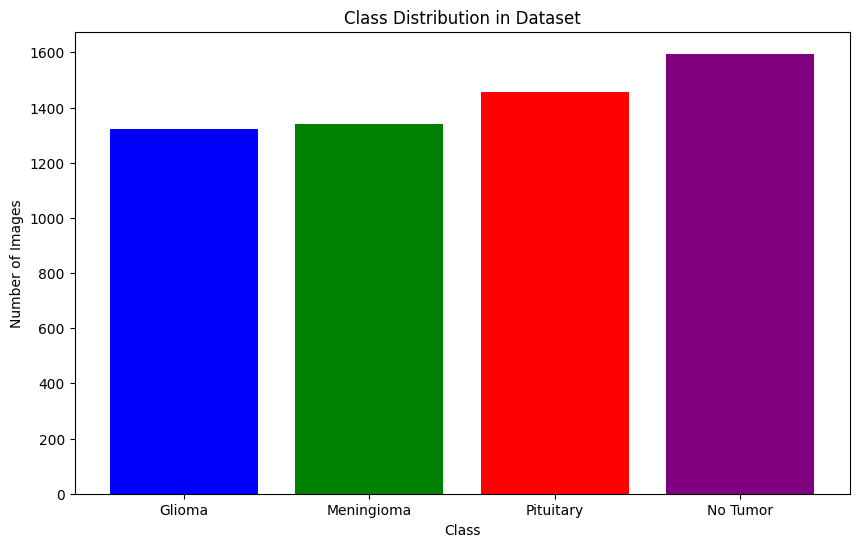


Training set shape: (4569, 150, 150, 3)
Validation set shape: (1143, 150, 150, 3)

Visualizing original vs augmented images...


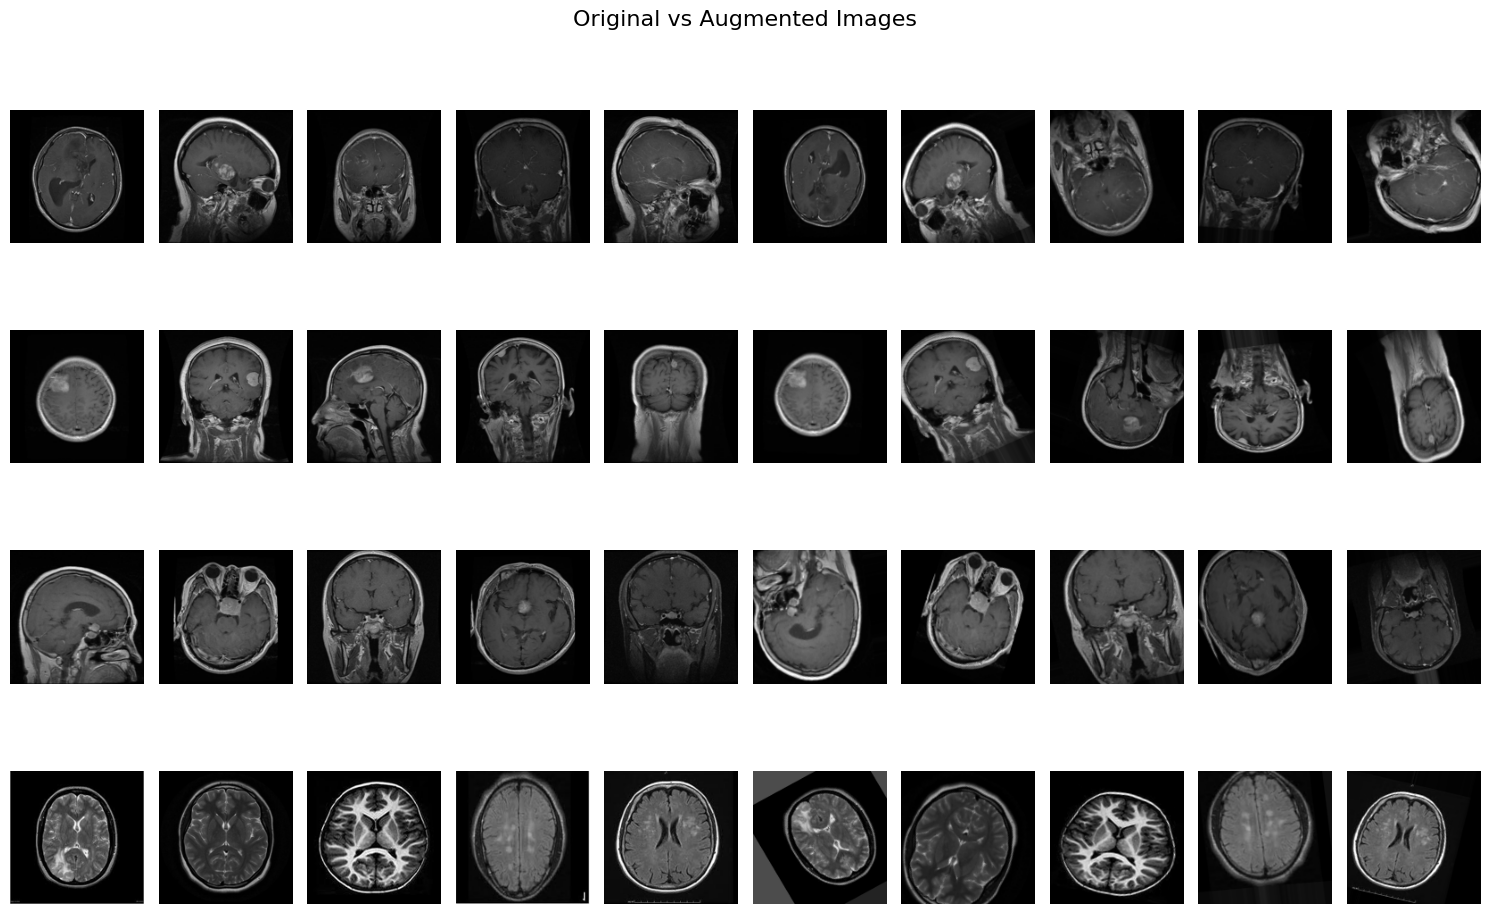


Balancing dataset with augmentation...


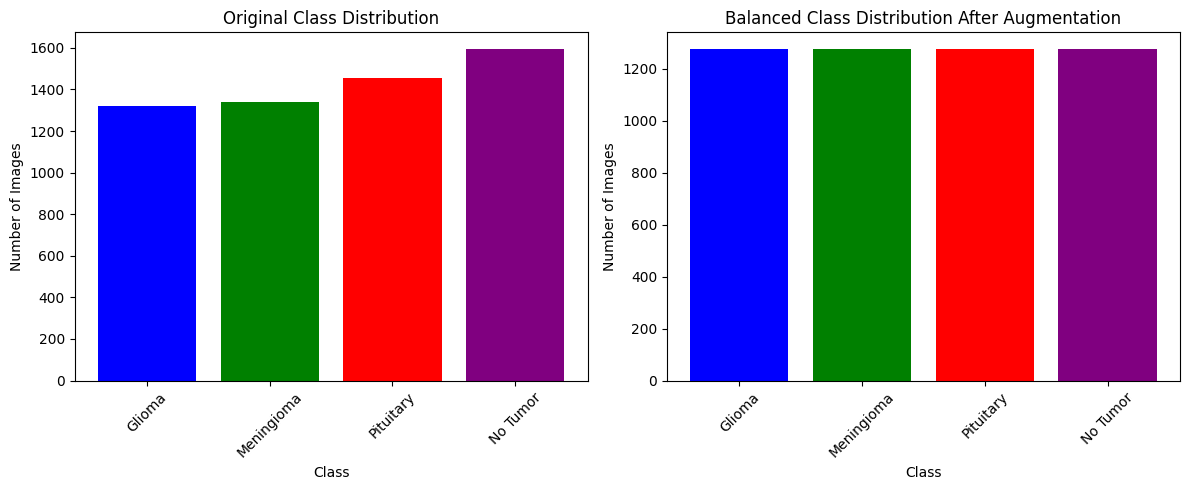


Dataset Preparation Complete!
Training samples: 5104
Validation samples: 1143
Batch size: 32
Number of classes: 4

Augmented data saved successfully to /content/processed_data!

Sample of augmented images for each class:


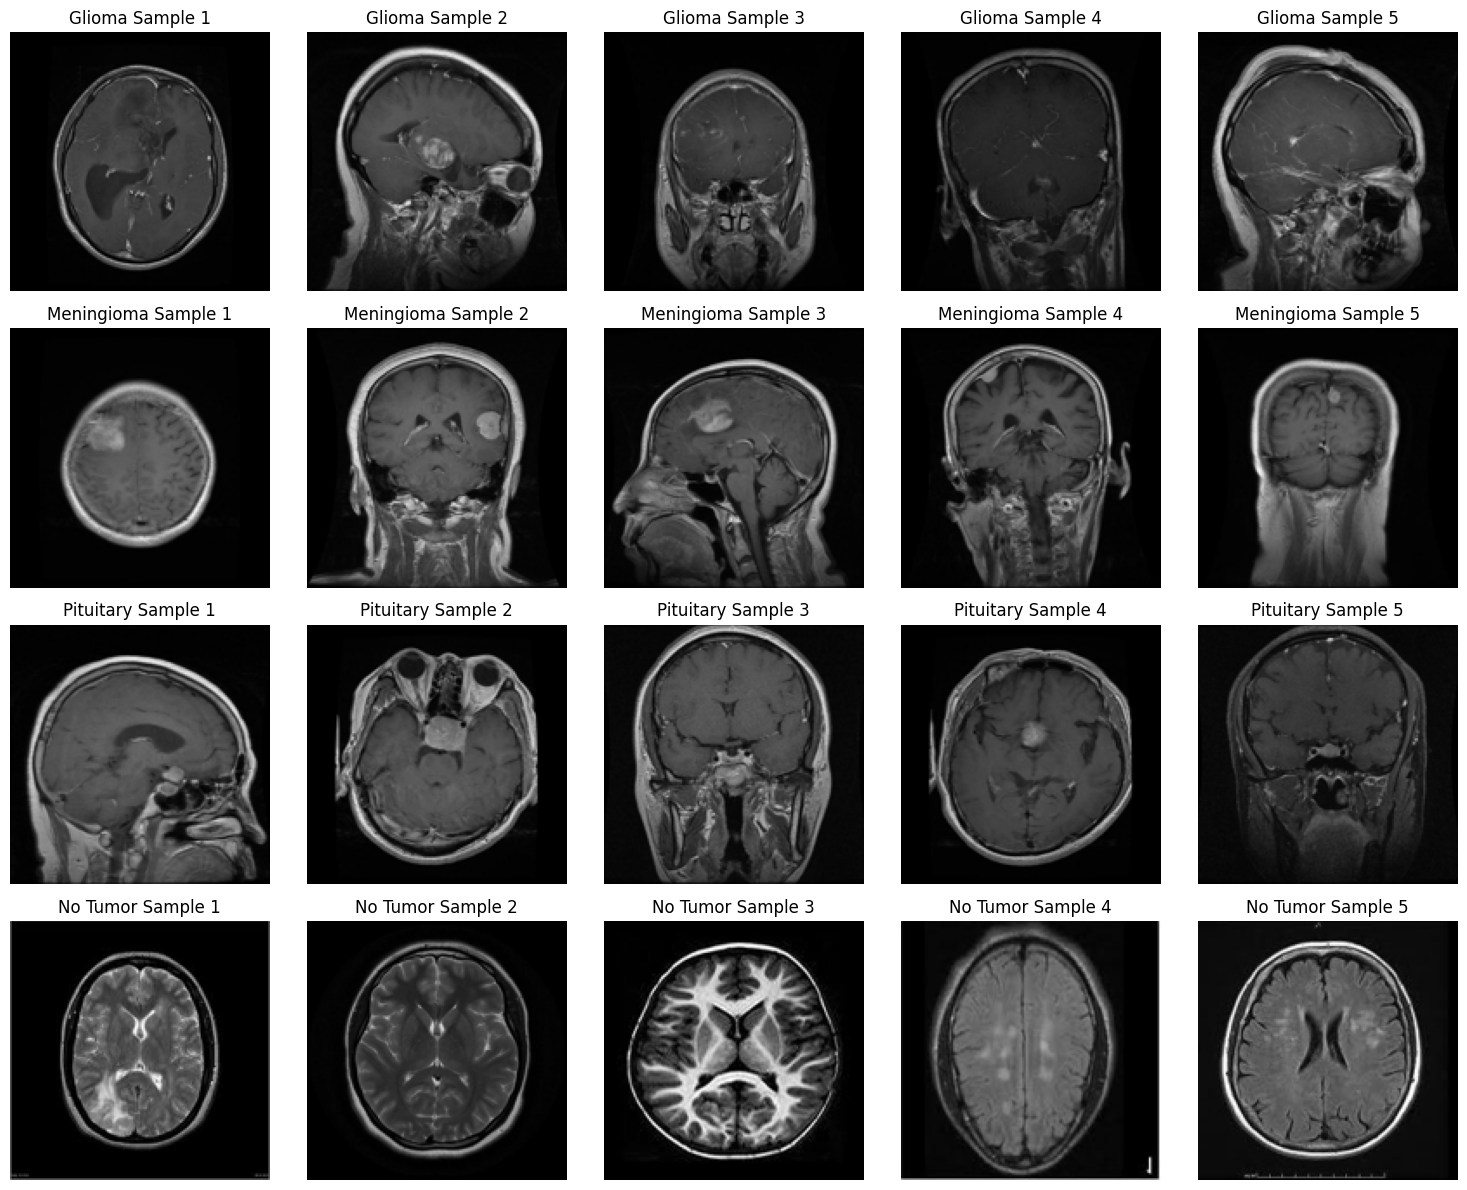


=== DATA AUGMENTATION SUMMARY ===
Original dataset size: 5712 images
After augmentation: 5104 images
Augmentation increased dataset by -608 images
Validation set size: 1143 images

Class distribution after augmentation:
Glioma: 1276 images
Meningioma: 1276 images
Pituitary: 1276 images
No Tumor: 1276 images


In [10]:
# Define correct paths based on the actual repository structure
training_path = train_dir
testing_path = test_dir

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split  # Import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from PIL import Image # Import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import ImageDataGenerator


glioma_path = os.path.join(training_path, 'glioma')
meningioma_path = os.path.join(training_path, 'meningioma')
pituitary_path = os.path.join(training_path, 'pituitary')
no_tumor_path = os.path.join(training_path, 'notumor')

# Check if paths exist
print("\nChecking paths:")
print("Glioma path exists:", os.path.exists(glioma_path))
print("Meningioma path exists:", os.path.exists(meningioma_path))
print("Pituitary path exists:", os.path.exists(pituitary_path))
print("No tumor path exists:", os.path.exists(no_tumor_path))

# Count files in each directory
def count_files(directory):
    if os.path.exists(directory):
        return len([f for f in os.listdir(directory) if f.endswith('.jpg') or f.endswith('.png')])
    return 0

print("\nNumber of images in each class:")
print("Glioma:", count_files(glioma_path))
print("Meningioma:", count_files(meningioma_path))
print("Pituitary:", count_files(pituitary_path))
print("No tumor:", count_files(no_tumor_path))

# Load and explore the dataset
def load_images(folder_path, label, img_size=(150, 150)):
    images = []
    labels = []
    if not os.path.exists(folder_path):
        print(f"Warning: Directory {folder_path} does not exist!")
        return np.array(images), np.array(labels)

    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(img_size)
                img_array = np.array(img)
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels)

# Load images from each class
img_size = (150, 150)  # Standard size for all images

print("\nLoading images...")
glioma_images, glioma_labels = load_images(glioma_path, 0, img_size)
meningioma_images, meningioma_labels = load_images(meningioma_path, 1, img_size)
pituitary_images, pituitary_labels = load_images(pituitary_path, 2, img_size)
no_tumor_images, no_tumor_labels = load_images(no_tumor_path, 3, img_size)

# Check if we have images from all classes
print(f"\nLoaded {len(glioma_images)} glioma images")
print(f"Loaded {len(meningioma_images)} meningioma images")
print(f"Loaded {len(pituitary_images)} pituitary images")
print(f"Loaded {len(no_tumor_images)} no tumor images")

# Combine all data
X = np.concatenate((glioma_images, meningioma_images, pituitary_images, no_tumor_images), axis=0)
y = np.concatenate((glioma_labels, meningioma_labels, pituitary_labels, no_tumor_labels), axis=0)

# Check the shape of the dataset
print(f"\nTotal images: {X.shape[0]}")
print(f"Image shape: {X.shape[1:]}")

# Display class distribution
class_names = ['Glioma', 'Meningioma', 'Pituitary', 'No Tumor']
class_counts = [len(glioma_labels), len(meningioma_labels), len(pituitary_labels), len(no_tumor_labels)]

plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts, color=['blue', 'green', 'red', 'purple'])
plt.title('Class Distribution in Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert labels to categorical
y_train_categorical = to_categorical(y_train, num_classes=4)
y_val_categorical = to_categorical(y_val, num_classes=4)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

# Data Augmentation Implementation
def create_augmentation_generator():
    """
    Create an ImageDataGenerator with various augmentation techniques
    """
    return ImageDataGenerator(
        rotation_range=30,        # Random rotation between -30 and 30 degrees
        width_shift_range=0.1,    # Random horizontal shift
        height_shift_range=0.1,   # Random vertical shift
        shear_range=0.2,          # Shear transformation
        zoom_range=0.2,           # Random zoom
        horizontal_flip=True,     # Random horizontal flip
        vertical_flip=True,       # Random vertical flip
        brightness_range=[0.8, 1.2],  # Random brightness adjustment
        fill_mode='nearest'       # Fill points outside boundaries
    )

# Create the augmentation generator
augmentation_generator = create_augmentation_generator()

# Visualize some original and augmented images
def visualize_augmentation(images, labels, augmentation_generator, num_samples=5):
    """
    Visualize original and augmented images for each class
    """
    fig, axes = plt.subplots(4, num_samples*2, figsize=(15, 10))
    fig.suptitle('Original vs Augmented Images', fontsize=16)

    for class_idx in range(4):
        # Get samples for this class
        class_images = images[labels == class_idx]
        if len(class_images) > 0:
            sample_images = class_images[:num_samples]

            for i in range(num_samples):
                # Original image
                axes[class_idx, i].imshow(sample_images[i].astype('uint8'))
                axes[class_idx, i].axis('off')
                if i == 0:
                    axes[class_idx, i].set_ylabel(class_names[class_idx], rotation=90, size='large')

                # Augmented image
                augmented = augmentation_generator.random_transform(sample_images[i].astype('float32'))
                axes[class_idx, i+num_samples].imshow(augmented.astype('uint8'))
                axes[class_idx, i+num_samples].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize augmentation for each class
print("\nVisualizing original vs augmented images...")
visualize_augmentation(X_train, y_train, augmentation_generator)

# Create a function to generate augmented data
def generate_augmented_data(X, y, augmentation_generator, augment_times=2):
    """
    Generate augmented data for minority classes to balance the dataset
    """
    # Count samples per class
    unique, counts = np.unique(y, return_counts=True)
    max_count = max(counts)

    X_augmented = [X]
    y_augmented = [y]

    for class_idx in range(len(unique)):
        class_count = counts[class_idx]
        if class_count < max_count:
            # Calculate how many augmentations we need
            needed = max_count - class_count
            class_images = X[y == class_idx]

            # Generate augmented images
            augmented_count = 0
            while augmented_count < needed:
                for img in class_images:
                    if augmented_count >= needed:
                        break
                    # Apply augmentation
                    augmented_img = augmentation_generator.random_transform(img.astype('float32'))
                    X_augmented.append(augmented_img[np.newaxis, ...])
                    y_augmented.append(np.array([class_idx]))
                    augmented_count += 1

    # Combine all data
    X_combined = np.concatenate(X_augmented, axis=0)
    y_combined = np.concatenate(y_augmented, axis=0)

    return X_combined, y_combined

# Apply augmentation to balance the dataset
print("\nBalancing dataset with augmentation...")
X_balanced, y_balanced = generate_augmented_data(X_train, y_train, augmentation_generator)

# Check the new class distribution
balanced_counts = [np.sum(y_balanced == i) for i in range(4)]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(class_names, class_counts, color=['blue', 'green', 'red', 'purple'])
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(class_names, balanced_counts, color=['blue', 'green', 'red', 'purple'])
plt.title('Balanced Class Distribution After Augmentation')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Create data generators for training with augmentation
batch_size = 32

# Training generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Validation generator (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow(
    X_balanced,
    to_categorical(y_balanced, num_classes=4),
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val,
    y_val_categorical,
    batch_size=batch_size,
    shuffle=False
)

# Print final dataset information
print("\nDataset Preparation Complete!")
print(f"Training samples: {X_balanced.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Batch size: {batch_size}")
print(f"Number of classes: {4}")

# Create directory to save processed data
output_dir = '/content/processed_data'
os.makedirs(output_dir, exist_ok=True)

# Save the preprocessed data for use in model training
np.save(os.path.join(output_dir, 'X_train_augmented.npy'), X_balanced)
np.save(os.path.join(output_dir, 'y_train_augmented.npy'), y_balanced)
np.save(os.path.join(output_dir, 'X_val.npy'), X_val)
np.save(os.path.join(output_dir, 'y_val.npy'), y_val)

print(f"\nAugmented data saved successfully to {output_dir}!")

# Display sample of augmented images
print("\nSample of augmented images for each class:")
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
for class_idx in range(4):
    class_images = X_balanced[y_balanced == class_idx]
    for i in range(5):
        if i < len(class_images):
            axes[class_idx, i].imshow(class_images[i].astype('uint8'))
            axes[class_idx, i].set_title(f'{class_names[class_idx]} Sample {i+1}')
            axes[class_idx, i].axis('off')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== DATA AUGMENTATION SUMMARY ===")
print(f"Original dataset size: {X.shape[0]} images")
print(f"After augmentation: {X_balanced.shape[0]} images")
print(f"Augmentation increased dataset by {X_balanced.shape[0] - X.shape[0]} images")
print(f"Validation set size: {X_val.shape[0]} images")
print("\nClass distribution after augmentation:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {balanced_counts[i]} images")

In [11]:
# Load images from training directory
image_paths = []
for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.endswith('.jpg'):
            image_paths.append(os.path.join(root, file))

# Load and preprocess images (subset for demo; use all for full run)
images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths[:100]]  # Grayscale for MRI
images = [cv2.resize(img, (128, 128)) for img in images if img is not None]  # Resize for consistency
print(f"Loaded {len(images)} images")

# Noise Removal - Median filter
denoised_images = [cv2.medianBlur(img, 3) for img in images]  # Kernel size 3

# Outlier Detection - Mean intensity
mean_intensities = [np.mean(img) for img in denoised_images]
df = pd.DataFrame({'mean_intensity': mean_intensities})

# IQR method
Q1 = df['mean_intensity'].quantile(0.25)
Q3 = df['mean_intensity'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
cleaned_indices = df[(df['mean_intensity'] >= lower_bound) & (df['mean_intensity'] <= upper_bound)].index
cleaned_images = [denoised_images[i] for i in cleaned_indices]

print(f"Original images: {len(denoised_images)}, After outlier removal: {len(cleaned_images)}")

# Save sample cleaned images
for i, img in enumerate(cleaned_images[:5]):
    cv2.imwrite(f'cleaned_image_{i}.jpg', img)

Loaded 100 images
Original images: 100, After outlier removal: 97


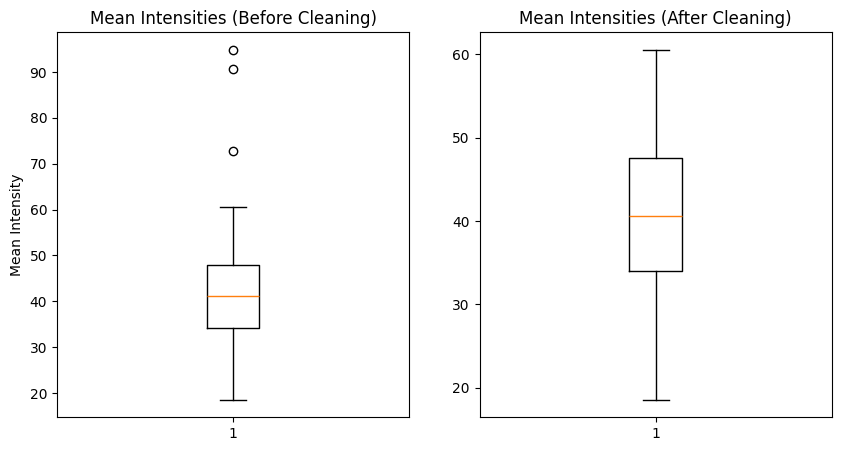

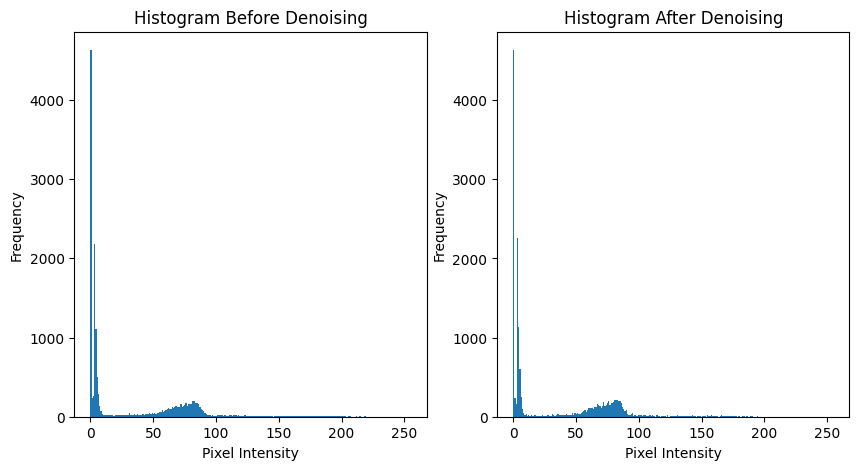

In [12]:
# EDA for Outlier/Noise Removal
# Boxplot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(mean_intensities)
plt.title('Mean Intensities (Before Cleaning)')
plt.ylabel('Mean Intensity')

plt.subplot(1, 2, 2)
plt.boxplot([np.mean(img) for img in cleaned_images])
plt.title('Mean Intensities (After Cleaning)')
plt.show()

# Histogram for noise
sample_idx = 0
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(images[sample_idx].ravel(), bins=256, range=(0, 255))
plt.title('Histogram Before Denoising')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(denoised_images[sample_idx].ravel(), bins=256, range=(0, 255))
plt.title('Histogram After Denoising')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Flatten cleaned images
flattened_images = np.array([img.flatten() for img in cleaned_images])

# Standardize data
scaler = StandardScaler()
scaled_images = scaler.fit_transform(flattened_images)

# Apply PCA
pca = PCA(n_components = len(cleaned_images))  # Adjust components as needed
reduced_images = pca.fit_transform(scaled_images)

print(f"Original shape: {flattened_images.shape}, Reduced shape: {reduced_images.shape}")

Original shape: (97, 16384), Reduced shape: (97, 97)


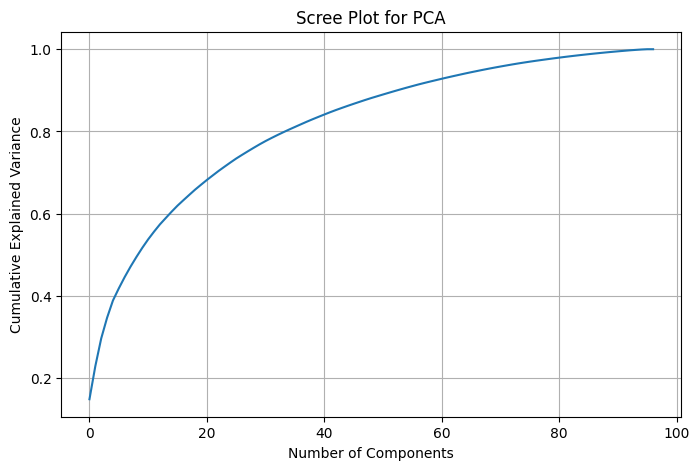

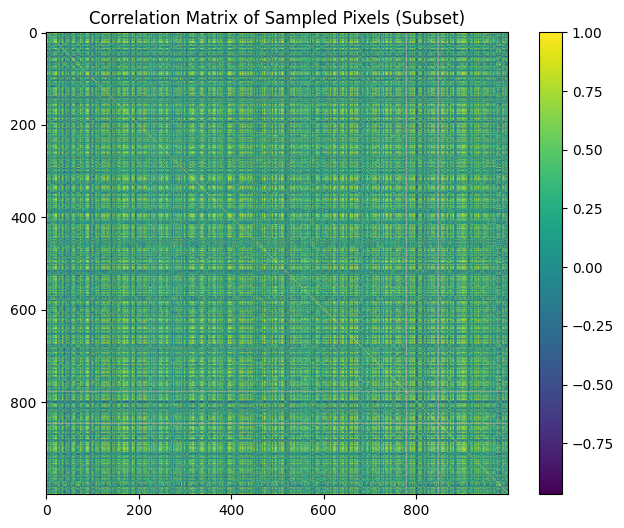

In [14]:
# EDA for Dimensionality Reduction
# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot for PCA')
plt.grid(True)
plt.show()

# Correlation matrix (subset to avoid memory issues)
n_pixels = 1000
random_pixels = np.random.choice(flattened_images.shape[1], size=n_pixels, replace=False)
subset_data = flattened_images[:10, random_pixels]  # Use 10 images, sampled pixels
corr_matrix = pd.DataFrame(subset_data).corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='viridis')
plt.title('Correlation Matrix of Sampled Pixels (Subset)')
plt.colorbar()
plt.show()